## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

## 1. Carga datos y representa la serie

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

import warnings
warnings.filterwarnings("ignore")


In [62]:
# Cargamos el dataset
df = pd.read_csv('data/AirPassengers.csv')


In [63]:
df

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [65]:
df.describe()

,value
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [66]:
# convertir en datatime
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)


date     datetime64[ns]
value             int64
dtype: object


In [67]:
# Extraer año
df['year'] = df['date'].dt.year

# Extraer mes
df['month'] = df['date'].dt.month

# Extraer día
df['day'] = df['date'].dt.day

# Extraer día de la semana (0 = lunes, 6 = domingo)
df['weekday'] = df['date'].dt.weekday



In [68]:
df


,date,value,year,month,day,weekday
0,1949-01-01,112,1949,1,1,5
1,1949-02-01,118,1949,2,1,1
2,1949-03-01,132,1949,3,1,1
3,1949-04-01,129,1949,4,1,4
4,1949-05-01,121,1949,5,1,6
...,...,...,...,...,...,...
139,1960-08-01,606,1960,8,1,0
140,1960-09-01,508,1960,9,1,3
141,1960-10-01,461,1960,10,1,5
142,1960-11-01,390,1960,11,1,1


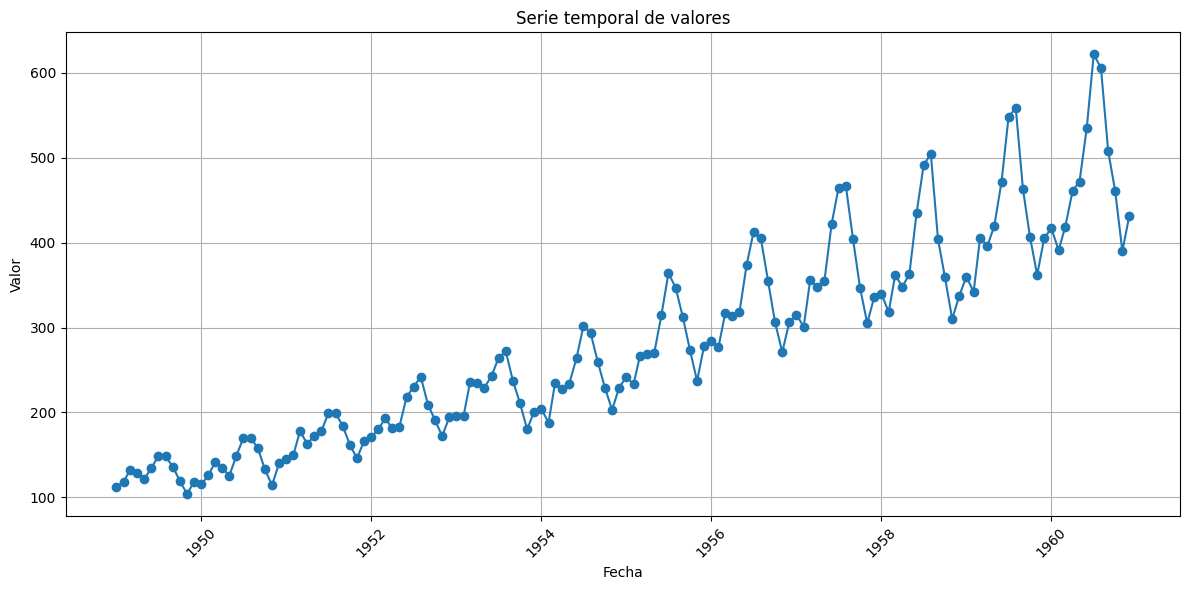

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Tamaño del gráfico
plt.plot(df['date'], df['value'], marker='o', linestyle='-')

plt.title('Serie temporal de valores')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.xticks(rotation=45)  # Rota etiquetas para mejor lectura
plt.tight_layout()
plt.show()


- Se aprecia con claridad un patrón que se repite año a año. Cada pico (máxima demanda) vuelve aproximadamente tras 12 meses, y del mismo modo los valles (“bajones”) aparecen cada 12-13 meses. La serie tiene estacionalidad anual, con periodo de 12 meses.

#### Descomposición de la serie temporal con seasonal_decompose de statsmodels:
- Este análisis separa la serie en:
- Tendencia (Trend)
- Estacionalidad (Seasonal)
- Ruido aleatorio (Residual)
- period=12 se usa si crees que hay un patrón anual con datos mensuales. Cambia este número según la frecuencia de tu serie.

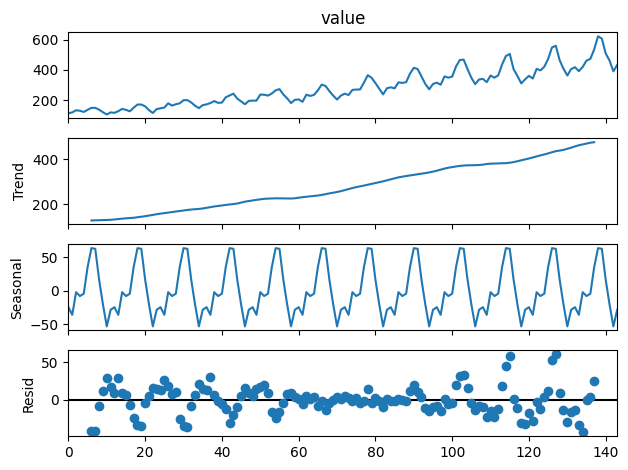

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


df = df.sort_index()
result = seasonal_decompose(df['value'], model='additive', period=12)  # Cambia period si es otra frecuencia

result.plot()
plt.show()


## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

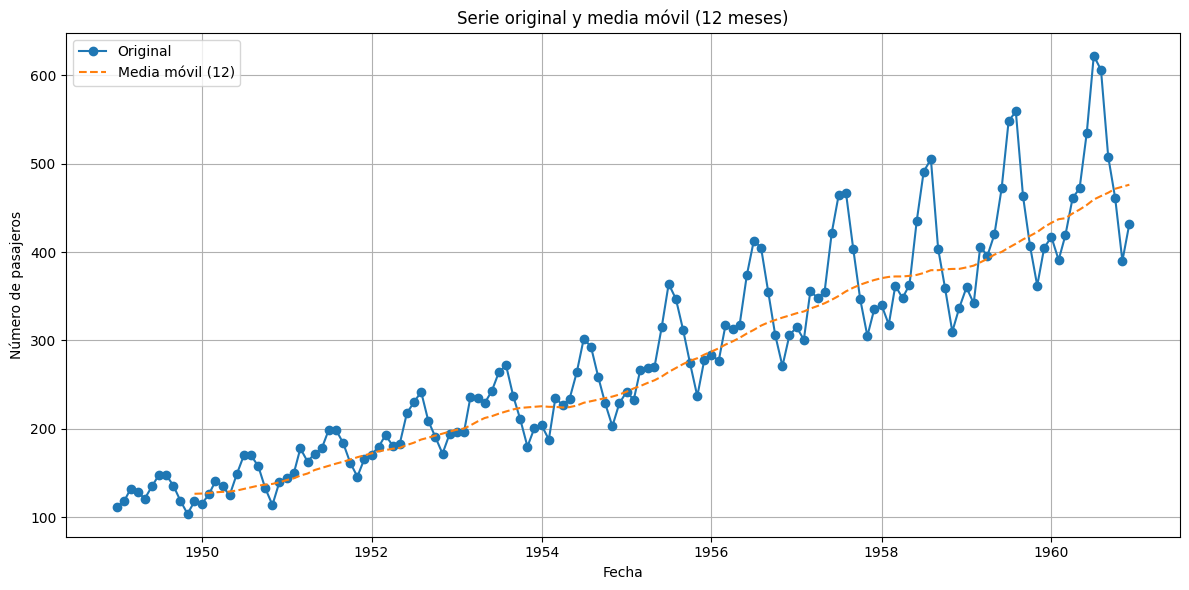

In [ ]:

# 2.1. Fijar el índice temporal
df.set_index('date', inplace=True)

# 2.2. Definir la estacionalidad 
seasonality = 12  # el ciclo es anual

# 2.3. Calculamos la media móvil
#     .rolling(window=12) agrupa en 12 filas (meses) 
#     .mean() calcula la media de cada ventana deslizante
df['rolling_mean'] = df['value'].rolling(window=seasonality).mean()

# 2.4. Graficar la serie original y su media móvil
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'],        label='Original',      marker='o', linestyle='-')
plt.plot(df.index, df['rolling_mean'], label=f'Media móvil ({seasonality})', linestyle='--')

plt.title('Serie original y media móvil (12 meses)')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- El rolling window de 12 meses elimina el ruido estacional y hace muy evidente la tendencia creciente subyacente, validando además que el ciclo se repite cada 12 meses.
- La “tendencia creciente subyacente” es la señal de que, más allá de los picos y valles anuales, la demanda de pasajeros está aumentando de forma sostenible a lo largo de los años. Se extrae suavizando o descomponiendo la serie y resulta clave para modelos de previsión y toma de decisiones a largo plazo.

## 3. Comprueba de manera estadística si la serie es o no stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# 3.1. Supongamos que 'df' ya tiene:
#       • índice datetime en df.index
#       • la serie en la columna 'value'
series = df['value']

# —— 3.2. Prueba ADF (Augmented Dickey–Fuller) ——
# H₀: la serie tiene raíz unitaria (no es estacionaria)
adf_res = adfuller(series, autolag='AIC')
print('--- ADF Test ---')
print(f"Estadístico ADF : {adf_res[0]:.4f}")
print(f"p-valor         : {adf_res[1]:.4f}")
print("Valores críticos:")
for nivel, val in adf_res[4].items():
    print(f"  {nivel} : {val:.4f}")
# Interpretación: si p-valor > 0.05 ⇒ no rechazamos H₀ ⇒ serie NO estacionaria

# —— 3.3. Prueba KPSS (Kwiatkowski–Phillips–Schmidt–Shin) ——
# H₀: la serie es estacionaria
# usamos regression='c' (constante) y dejamos nlags automático
kpss_res = kpss(series, regression='c', nlags='auto')
print('\n--- KPSS Test ---')
print(f"Estadístico KPSS : {kpss_res[0]:.4f}")
print(f"p-valor           : {kpss_res[1]:.4f}")
print("Valores críticos:")
for nivel, val in kpss_res[3].items():
    print(f"  {nivel} : {val:.4f}")
# Interpretación: si p-valor < 0.05 ⇒ rechazamos H₀ ⇒ serie NO estacionaria

# —— 3.4. Conclusión combinada ——
# • ADF no rechaza raíz unitaria ⇒ no estacionaria
# • KPSS rechaza estacionariedad     ⇒ no estacionaria
# En ambos casos, concluimos que la serie original NO es estacionaria.

--- ADF Test ---
Estadístico ADF : 0.8154
p-valor         : 0.9919
Valores críticos:
  1% : -3.4817
  5% : -2.8840
  10% : -2.5788

--- KPSS Test ---
Estadístico KPSS : 1.6513
p-valor           : 0.0100
Valores críticos:
  10% : 0.3470
  5% : 0.4630
  2.5% : 0.5740
  1% : 0.7390


#### Con esos resultados se confirma que la serie original no es estacionaria:
- **(ADF: detecta presencia de raíz unitaria. Un p-valor alto (>0.05) indica no estacionariedad.)**
- ADF Test: Estadístico = 0.8154, p-valor = 0.9919 (≫ 0.05) ⇒ no rechazamos H₀ (hay raíz unitaria) ⇒ no estacionaria.
- **(KPSS: asume estacionariedad como nula; un p-valor bajo (<0.05) también señala no estacionariedad.)**
- KPSS Test: Estadístico = 1.6513, p-valor ≈ 0.01 (< 0.05) ⇒ rechazamos H₀ (no es estacionaria) ⇒ no estacionaria.
En ambos casos concluimos que la serie tiene tendencia y/o estacionalidad que hay que eliminar antes de modelar.

## 4. Aplica una transformación logarítmica

- La varianza creciente es cuando tus datos “ruidosos” fluctúan cada vez más a medida que sube la serie o avanza el tiempo. Identificarla y corregirla (por ejemplo, con un logaritmo) es clave para que tus modelos de forecasting funcionen de forma fiable.


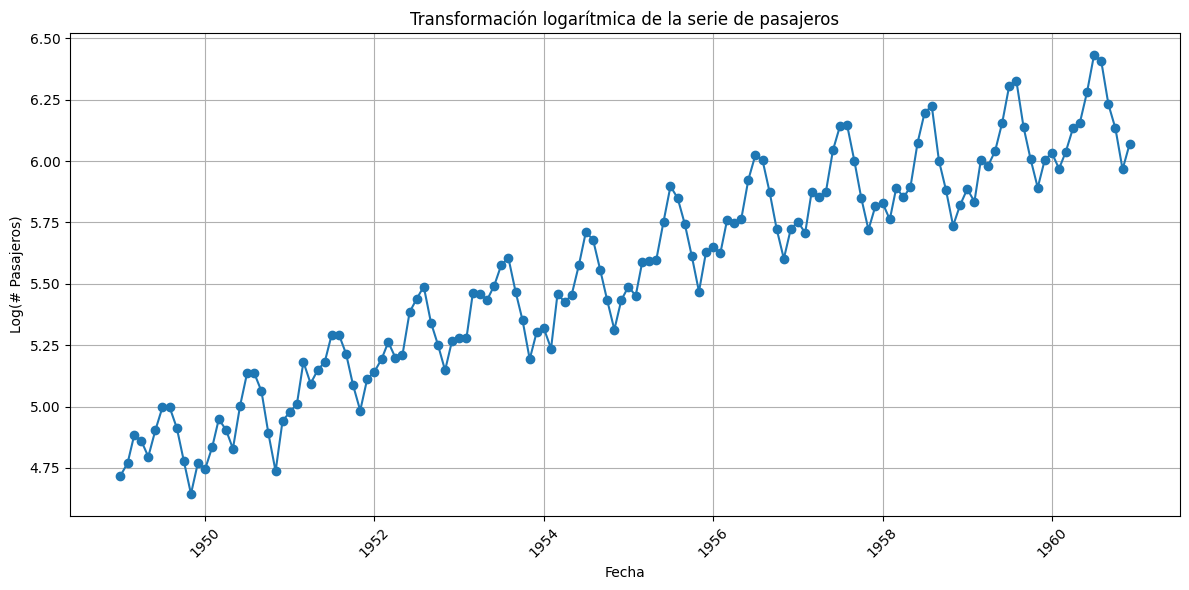

In [ ]:

# 4.1. Partimos de la serie original (índice datetime, columna 'value')
series = df['value']

# 4.2. Aplicamos la transformación logarítmica natural
#      Esto ayuda a estabilizar la varianza (reduce heterocedasticidad)
series_log = np.log(series)

# 4.3. Graficamos la serie transformada
plt.figure(figsize=(12, 6))
plt.plot(series_log.index, series_log.values, marker='o', linestyle='-')
plt.title('Transformación logarítmica de la serie de pasajeros')
plt.xlabel('Fecha')
plt.ylabel('Log(# Pasajeros)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Oscila dentro de un rango de valores más corto

## 5. Divide en train y test. Guarda 20 muestras para test.

In [84]:
from sklearn.model_selection import train_test_split

n_test = 20
train_log = series_log.iloc[:-n_test]
test_log  = series_log.iloc[-n_test:]

# También guardamos las originales para la evaluación final
train_orig = series.iloc[:-n_test]
test_orig  = series.iloc[-n_test:]

print(f"\nTrain: {len(train_log)} muestras, Test: {len(test_log)} muestras")
print(f"Train va de {train_log.index[0].date()} a {train_log.index[-1].date()}")
print(f"Test  va de {test_log.index[0].date()} a {test_log.index[-1].date()}")


Train: 124 muestras, Test: 20 muestras
Train va de 1949-01-01 a 1959-04-01
Test  va de 1959-05-01 a 1960-12-01


## 6. Crea tu primer modelo ARIMA

In [92]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, seasonality

model = ARIMA(
    train_log,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m)
)
model_fit = model.fit()
print('\n', model_fit.summary())

# Forecast en escala logarítmica
forecast_log = model_fit.forecast(steps=n_test)
# Revertimos a escala original
forecast = np.exp(forecast_log)

# Métricas de error
mae  = mean_absolute_error(test_orig, forecast)
rmse = np.sqrt(mean_squared_error(test_orig, forecast))
print(f'\nARIMA MAE : {mae:.2f}')
print(f'ARIMA RMSE: {rmse:.2f}')




                                     SARIMAX Results                                     
Dep. Variable:                            value   No. Observations:                  124
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 206.543
Date:                         mi., 07 may. 2025   AIC                           -403.087
Time:                                  00:25:59   BIC                           -389.539
Sample:                              01-01-1949   HQIC                          -397.591
                                   - 04-01-1959                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2580      0.256      1.010      0.313      -0.243       0.759
ma.L1         -0.5905      0.223     -2.649      

## 7. Representa en una gráfica los datos de test y tus predicciones.

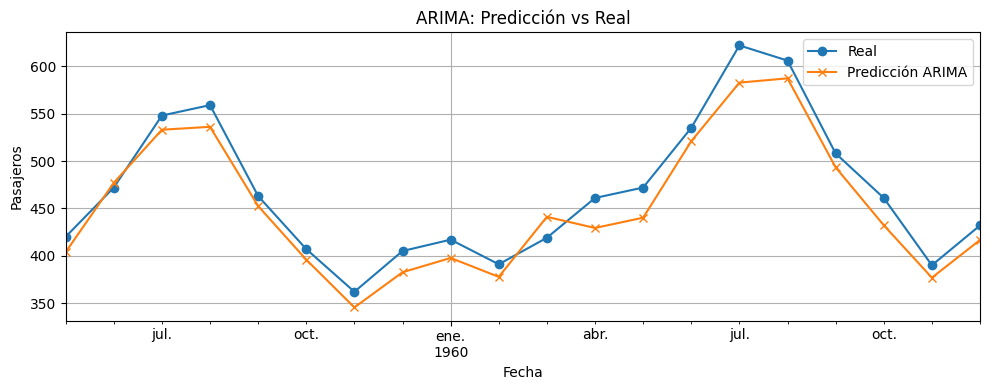

In [91]:
# Gráfico de Predicción vs Real
plt.figure(figsize=(10, 4))
test_orig.plot(label='Real', marker='o')
forecast.plot(label='Predicción ARIMA', marker='x')
plt.title('ARIMA: Predicción vs Real')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Prueba otros modelos, a ver qué performance presentan.

Decision Tree   MAE = 40.55, RMSE = 52.63
Random Forest   MAE = 39.99, RMSE = 55.53


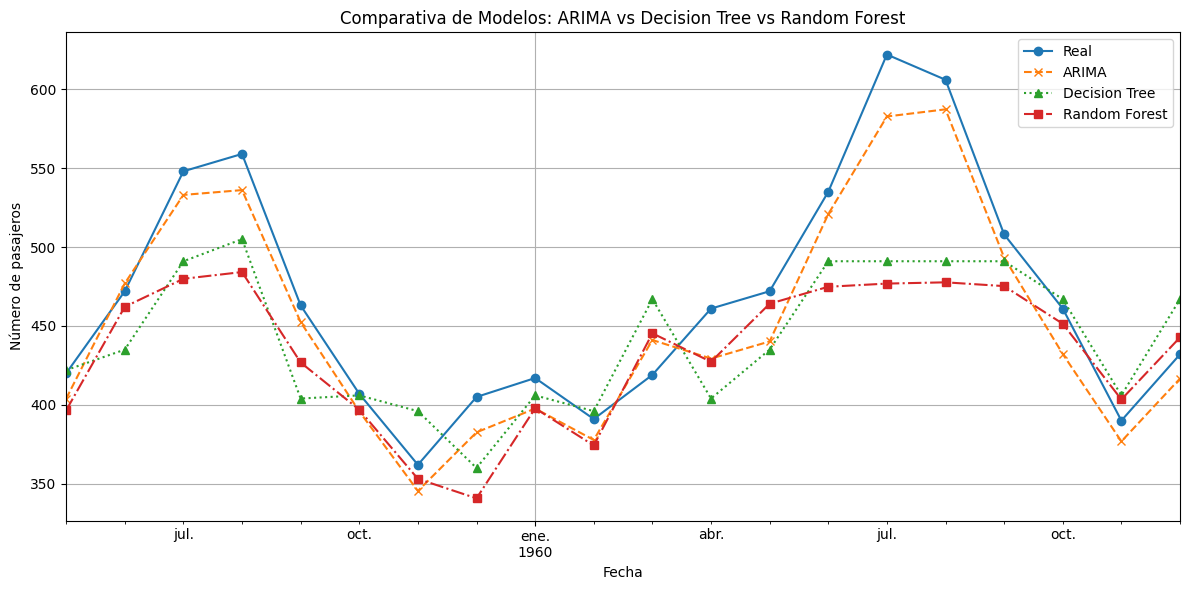

In [93]:
# 8.1. Construir el DataFrame supervisado con rezagos de la serie logarítmica
df_sup = pd.DataFrame({'y': series_log})
for lag in range(1, seasonality + 1):
    df_sup[f'lag_{lag}'] = df_sup['y'].shift(lag)
df_sup.dropna(inplace=True)

# 8.2. Separar en X e y, y luego en train/test según los índices temporales
train_end = train_log.index[-1]

X = df_sup.drop('y', axis=1)
y = df_sup['y']

X_train = X.loc[:train_end]
y_train = y.loc[:train_end]

X_test = X.loc[test_log.index]
y_test = y.loc[test_log.index]

# 8.3. Entrenar y predecir con Decision Tree
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train, y_train)
pred_dt_log = dt.predict(X_test)
pred_dt     = np.exp(pred_dt_log)  # invertimos log

# 8.4. Entrenar y predecir con Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
pred_rf_log = rf.predict(X_test)
pred_rf     = np.exp(pred_rf_log)  # invertimos log

# 8.5. Calcular métricas sobre la serie original de test
mae_dt  = mean_absolute_error(test_orig, pred_dt)
rmse_dt = np.sqrt(mean_squared_error(test_orig, pred_dt))

mae_rf  = mean_absolute_error(test_orig, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(test_orig, pred_rf))

print(f'Decision Tree   MAE = {mae_dt:.2f}, RMSE = {rmse_dt:.2f}')
print(f'Random Forest   MAE = {mae_rf:.2f}, RMSE = {rmse_rf:.2f}')

# 8.6. Gráfico comparativo de los tres modelos
plt.figure(figsize=(12, 6))

# Datos reales
test_orig.plot(label='Real', marker='o', linestyle='-')

# Predicción ARIMA (asumimos forecast ya calculado y con mismo índice que test_orig)
forecast.index = test_orig.index
forecast.plot(label='ARIMA', marker='x', linestyle='--')

# Predicciones tree-based
pd.Series(pred_dt, index=test_orig.index).plot(
    label='Decision Tree', marker='^', linestyle=':'
)
pd.Series(pred_rf, index=test_orig.index).plot(
    label='Random Forest', marker='s', linestyle='-.'
)

plt.title('Comparativa de Modelos: ARIMA vs Decision Tree vs Random Forest')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Hay que hacer la predicción en el dataset originales, yo no lo he hecho

In [3]:
# df_2 = pd.read_csv('data/AirPassengers.csv')
# df_2